In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import linear_model as lm
from sklearn.utils import shuffle

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [3]:
# class = 0 => Original, class = 1 => Forged
df = pd.read_csv('BankNote_Authentication.csv')
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [96]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [137]:
class LogisticRegression:
    def __init__(self, X, Y, learning_rate: float):
        X, Y = shuffle(X, Y)
        X, Y = np.array(X, dtype=float), np.array(Y)
        
        # X => Feature Vectors of training set
        self.m, self.n = X.shape # m => No. of training examples, n => No. of features
        
        # feature_stats => (mean, stddev) for each feature
        self.feature_stats = [(np.mean(feature), np.std(feature)) for feature in X.T]
        
        # Mean Normalizing the features
        self.mean_normalize(X)

        # Feature (column)Vectors, x0 = 1
        self.X = np.array([np.append(1, x).reshape(-1, 1) for x in X], dtype=float)
        self.Y = np.array(Y) # Output corresponding to each feature vector
        self.learning_rate = learning_rate
        self.theta = np.random.rand(self.n + 1, 1)
    

    def mean_normalize(self, X: np.ndarray):
        for i, (feature, (mean, stddev)) in enumerate(zip(X.T, self.feature_stats)):
            X.T[i] = (feature - mean) / stddev


    # x => Feature Vector with x0 = 1 (n + 1 dimensional column vector)
    def h(self, theta, x) -> float:
        return sigmoid(theta.T.dot(x)[0][0])
    
    # Cost Function
    def J(self, theta, X, Y) -> float:
        return (-1 / len(X)) * sum(
            (y * np.log(self.h(theta, x))) + ((1 - y) * np.log(1 - self.h(theta, x))) for x, y in zip(X, Y)
        )
    

    def has_converged(self, old_cost, new_cost) -> bool:
        return abs(old_cost - new_cost) < 10 ** -6


    # Returns the list 'cost' containing the costs after each gradient descent step.
    # Ideally it should be in the decreasing order.
    def gradient_descent(self):
        cost = [self.J(self.theta, self.X, self.Y)]

        while True:
            print(cost[-1])
            gradient_vector = (1 / self.m) * sum(
                (self.h(self.theta, x) - y) * x for x, y in zip(self.X, self.Y)
            )

            new_theta = self.theta - self.learning_rate * gradient_vector
            new_cost = self.J(new_theta, self.X, self.Y)

            if self.has_converged(cost[-1], new_cost):
                break

            self.theta = new_theta
            cost.append(new_cost)
        
        return cost


    def mini_batch_gradient_descent(self, batch_size=10):
        num_batches = self.m // batch_size
        cost = [0]
        while True:
            cur_cost = 0
            for i in range(0, self.m, batch_size):
                X_batch, Y_batch = self.X[i : i + batch_size], self.Y[i : i + batch_size]

                cur_cost += self.J(self.theta, X_batch, Y_batch)

                gradient_vector = (1 / len(X_batch)) * sum(
                    (self.h(self.theta, x) - y) * x for x, y in zip(X_batch, Y_batch)
                )

                self.theta = self.theta - self.learning_rate * gradient_vector
            
            avg_cost = cur_cost / num_batches
            
            if (self.has_converged(cost[-1], avg_cost)):
                break
            
            cost.append(avg_cost)
        
        return cost[1:]


    # X => Feature Vectors (list of n dimensional row vectors)
    def predict(self, X) -> float:
        X = np.array(X, dtype=float)
        # Mean Normalizing the Feature Vectors
        self.mean_normalize(X)
        X = [np.append(1, x).reshape(-1, 1) for x in X] # adding x0 = 1
        return [1 if self.h(self.theta, x) >= 0.5 else 0 for x in X]
    
    
    # X => Feature Vectors (list of n dimensional row vectors)
    def predict_proba(self, X) -> float:
        X = np.array(X, dtype=float)
        # Mean Normalizing the Feature Vectors
        self.mean_normalize(X)
        X = [np.append(1, x).reshape(-1, 1) for x in X] # adding x0 = 1
        return [[1 - self.h(self.theta, x), self.h(self.theta, x)] for x in X]

    
    # Returns the accuracy => (Correct Predictions / Total Predictions)
    def score(self, X, Y) -> float:
        pred_Y = self.predict(X)
        return (1 / len(X)) * np.sum(pred_Y == Y)

In [98]:
def visualize_gradient_descent(cost):
    ax = sns.lineplot(x=list(range(len(cost))), y=cost, marker='o')
    ax.set(xlabel='Iterations', ylabel='Cost', title='Cost vs Iterations')
    plt.show()

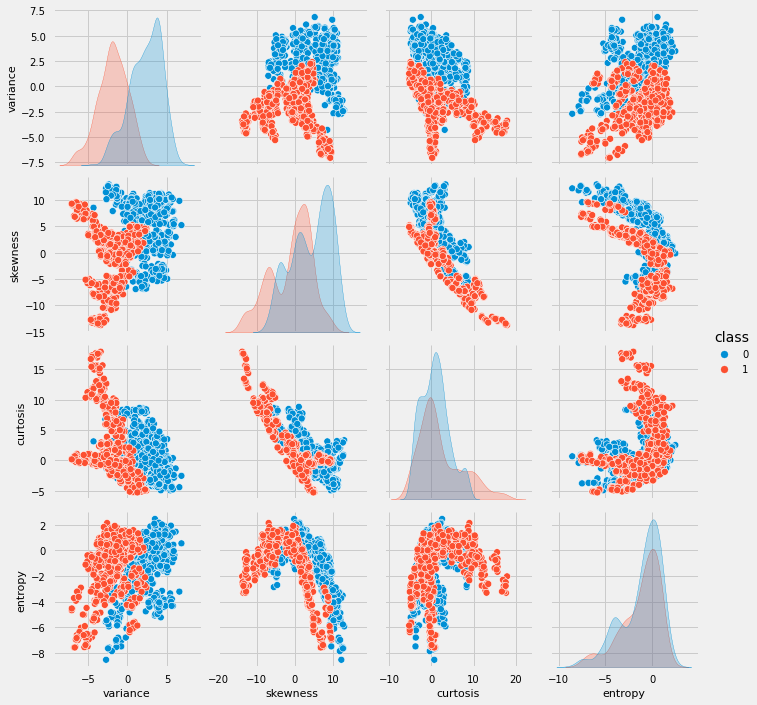

In [30]:
sns.pairplot(data=df, hue='class')
plt.show()

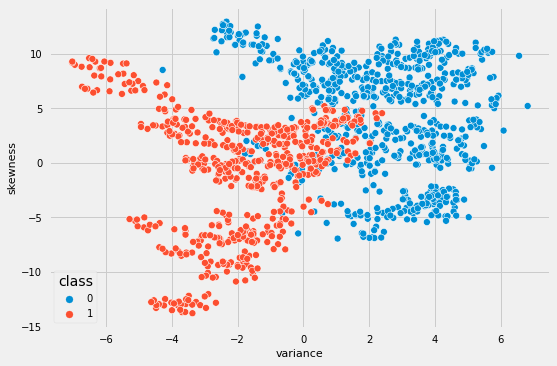

In [22]:
sns.scatterplot(x='variance', y='skewness', data=df, hue='class')
plt.show()

In [123]:
X = np.array(list(zip(df['variance'], df['skewness'])))
Y = df['class'].values
X, Y

(array([[  3.6216 ,   8.6661 ],
        [  4.5459 ,   8.1674 ],
        [  3.866  ,  -2.6383 ],
        ...,
        [ -3.7503 , -13.4586 ],
        [ -3.5637 ,  -8.3827 ],
        [ -2.5419 ,  -0.65804]]),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64))

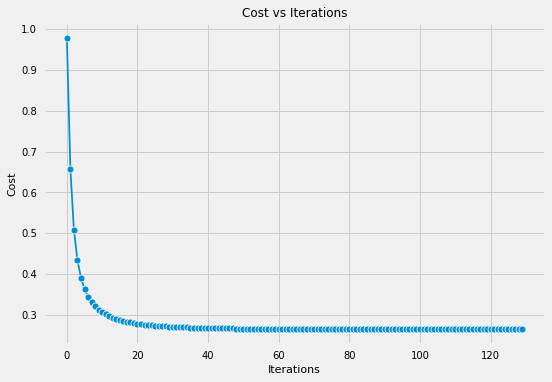

In [129]:
model = LogisticRegression(X, Y, 0.01)
cost = model.mini_batch_gradient_descent()
visualize_gradient_descent(cost)

In [138]:
model.theta

array([[-0.4078171 ],
       [-3.13827637],
       [-1.58261855]])

In [89]:
b_model = lm.LogisticRegression().fit(X, Y)

In [90]:
b_model.coef_, b_model.intercept_

(array([[-1.10599228, -0.27171153]]), array([0.58396241]))

In [147]:
print(f'Mini Batch GD Score = {model.score(X, Y)}')
print(f'sklearn Score = {b_model.score(X, Y)}')

Mini Batch GD Score = 0.8862973760932944
sklearn Score = 0.8855685131195336


In [141]:
probs = np.array(model.predict_proba(X))
print(probs)
indices = [i for i, p in enumerate(probs.T[0]) if abs(p - 0.5) < 10 ** -2]
print(indices)

[[9.96819408e-01 3.18059199e-03]
 [9.98686482e-01 1.31351772e-03]
 [9.51107628e-01 4.88923715e-02]
 ...
 [2.33543010e-04 9.99766457e-01]
 [1.12753144e-03 9.98872469e-01]
 [2.72675370e-02 9.72732463e-01]]
[170, 200, 226, 248, 388, 404, 425, 436, 476, 498, 668, 684, 691, 728, 926, 1080]


In [142]:
b_indices = [i for i, p in enumerate(b_model.predict_proba(X).T[0]) if abs(p - 0.5) < 10 ** -2]
b_indices

[248, 359, 404, 420, 425, 436, 476, 728, 897, 926, 1080]

In [143]:
decision_boundary = X[indices]
b_decision_boundary = X[b_indices]

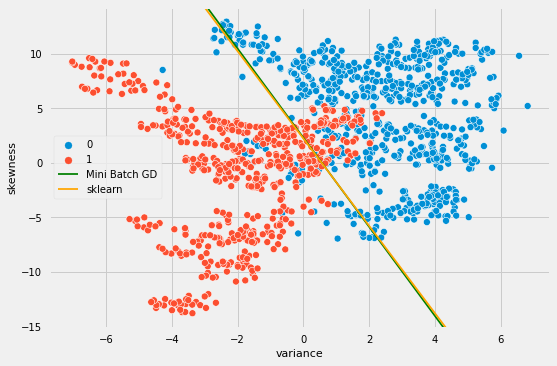

In [146]:
sns.scatterplot(x='variance', y='skewness', data=df, hue='class')
plt.axline(xy1=decision_boundary[0], xy2=decision_boundary[1], color='green', label='Mini Batch GD')
plt.axline(xy1=b_decision_boundary[0], xy2=b_decision_boundary[1], color='orange', label='sklearn')
plt.legend()
plt.show()